# SDID Example
hsujulia
30oct2022
___

**To-do-List**
1. Code up inference result, choosing from **Algorithms 2,3, and 4** which are the *Bootstrap Variance*, *Jacknife Variance*, and *Placebo Variance* verions, respectively.

___

This paper tries to implement the Synthetic Difference-in-Differences (SDiD, hereafter) following [Arkhangelsky, Athey, Hirschberg, Imbens, and Wager (2021) ](https://arxiv.org/pdf/1812.09970.pdf). Callout to the R Package written by Hirschberge, [synthdid](https://synth-inference.github.io/synthdid/).

At a high-level, we want to estimate the tuple $(\hat{\tau}^{sdid}, \hat{\mu} , \hat{\alpha}, \hat{\beta}) $ to minimize:
$$\sum^N_{i=1} \sum^T_{t=1} \big( Y_{it} - \mu - \alpha_i - \beta_t - W_{it} \tau \big)^2 \hat{\omega}^{sdid}_i \hat{\lambda}^{sdid}_t $$

Where $\omega_i$ are unit-varying weights, and $\lambda$ are time-varying weights.

For reference, we can write Difference-in-Differences (DiD) and synthetic control (SC) models as:
* SDiD: $(\hat{\tau}^{SDiD}, \hat{\mu} , \hat{\alpha}, \hat{\beta}) = \text{arg min} \Big \{ \sum^N_{i=1} \sum^T_{t=1} \big( Y_{it} - \mu - \alpha_i - \beta_t - W_{it} \tau \big)^2 \hat{\omega}^{sdid}_i \hat{\lambda}^{sdid}_t \Big \}$ 
* DiD: $(\hat{\tau}^{DiD}, \hat{\mu} , \hat{\alpha}, \hat{\beta}) = \text{arg min} \Big \{ \sum^N_{i=1} \sum^T_{t=1} \big( Y_{it} - \mu - \alpha_i - \beta_t - W_{it} \tau \big)^2 \Big \}$ 
* SC: $(\hat{\tau}^{SC}, \hat{\mu} , \hat{\alpha}, \hat{\beta}) = \text{arg min} \Big \{ \sum^N_{i=1} \sum^T_{t=1} \big( Y_{it} - \mu - \alpha_i - \beta_t - W_{it} \tau \big)^2 \hat{\omega}^{sc}_i  \Big \}$.
    - Note that if we use SC defined by Abadie, [Diamond, and Hainmueller (201)](https://web.stanford.edu/~jhain/Paper/JASA2010.pdf), $\alpha = 0$ 





## Implementation following SDiD Paper (Arkhangelsky et al.)
**Algorithm (called Algorithm 1 from the SDiD paper)**

Notation:
1. Outcome trend $Y_{it}$ for units $i$ and time periods $t$.
2. For $t = 1,..., T_{pre}$, no units are treated. For $t = T_{post}$ periods, some units started to be treated. 
2. $W_{it}$ indicates unit-time instances that are treated. 
3. $N_{co}$ control units, and $N_{tr}$ treated units.
4. This means that units $i=1,..., N_{co}$ are control units, and $i = N_{co}+1,...,N$ are treated.

### 1. Compute regularization parameter $\zeta$ 
The regularization parameter, $\zeta$ will be used in the second step. It can be directly calculated from the data, without any optimization. Following the SDiD paper. This is basically the variance in year-to-year change in pre-treatment time outcomes among units from the control donor units.
$$\zeta = (N_{tr} T_{post} )^{\frac{1}{4}} \big( \frac{1}{N_{co}(T_{pre}-1)}\sum^{N_{co}}_{i=1} \sum^{T_{pre}-1}_{t=1} (\Delta_{it} - \bar{\Delta})^2 \big) $$
$\Delta_{it} = Y_{i \{t+1\}} - Y_{it}$, and
$\bar{\Delta} = \frac{1}{N_{co}(T_{pre}-1)}\sum^{N_{co}}_{i=1} \sum^{T_{pre}-1}_{t=1} \Delta_{it} $
### 2. Compute unit weights $\omega^{sdid}$ 
Let $\omega^{sdid} = (\omega_0, \omega^{sdid}_i)$, which we estimate to minimize pre-treatment outcomes among control and treated units. We use the regularization term above with an L2 regularization (the squared one, not the absolute one) of the parameters and $\zeta$ above to allow a unique solution.

$$ (\hat{\omega}_0, \hat{\omega}^{sdid}_i) = \text{arg min} \Big\{ 
\sum^{T_{pre}}_{t=1} (
    \omega_0 + \sum^{N_{co}}_{i=1} \omega_i Y_{it} - \frac{1}{ N_{tr}} \sum^N_{i = N_{co}+1} Y_{it}
)^2 + \zeta^2 T_{pre} ||\omega||^2_2
\Big\} : \sum^{N_{co}}_{i=1} \omega_i = 1$$ 

### 3. Compute unit weights $\lambda^{sdid}$ 
Let $\lambda^{sdid}= (\hat{\lambda}_0, \hat{\lambda}^{sdid}_t)$, which we use to predict the post-treatment trend of control units by weighting the pre-treatment trend of control units.  
$$  (\hat{\lambda}_0, \hat{\lambda}^{sdid}_t)  = \text{arg min} \Big\{
\sum^{N_{co}}_{i=1} (\lambda_0 + \sum^{T_{pre}}_{t=1}\lambda_t Y_{it} - \frac{1}{T_{post}}\sum^T_{t=T_{pre}+1}Y_{it} )
\Big\} : \sum^{T_{pre}}_{t=1}\lambda_t = 1 $$
### 4. Compute SDiD Estimator 
With the unit and time weights- $(\hat{\omega}^{sdid}_i)$ and $(\hat{\lambda}^{sdid}_t)$ - respectively, we can estimate our estimate of interest. Note that we omit the constants $\hat{\omega}_0$ and $\hat{\lambda}_0$.

$$  (\hat{\tau}^{SDiD}, \hat{\mu} , \hat{\alpha}, \hat{\beta}) = \text{arg min} \Big \{ \sum^N_{i=1} \sum^T_{t=1} \big( Y_{it} - \mu - \alpha_i - \beta_t - W_{it} \tau \big)^2 \hat{\omega}^{sdid}_i \hat{\lambda}^{sdid}_t \Big \}$$ 

In [1]:
import pandas as pd
import numpy as np
import os as os 

import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.display import display    

import scipy.stats 
from sklearn.linear_model import ElasticNet
import statsmodels.api as sm

from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import minimize, fmin_slsqp



## Code up DGP and SDiD Model.
For the DGP, we will borrow the DGP functions from the *SC_0_SC_Balancing_DiD_Regression.ipynb* Notebook.



In [2]:
class dgp:    
    def panel_station(seed_number = 2739,
                     pre_time_units = 20,
                     pst_time_units = 5,
                     x_units_control = 15,
                     x_units_treat = 5,                      
                     K_dim = 5,
                     at = 2):
        '''
        seed_number  random_number_set
        pre_time_units   how many pre-treatment time periods?
        pst_time_units   how many post-treatment time periods?
        x_units      how many units?
        K_dim        how many covariates (assume uniform)
        at           ATET estimate
        '''        
        time_units = pre_time_units + pst_time_units
        t_range = pd.date_range(pd.to_datetime('2020/01/01'), periods=time_units, freq="M")
        x_units = x_units_control+x_units_treat
        u_range = range(x_units)
        sigma_epsilon = 1
        rho = 0.75


        df_return = pd.DataFrame(index=list(u_range)*time_units, 
                     columns=['date'],
                     data= np.array( [ [p]*x_units for p in t_range] ).flatten() )
        df_return.reset_index(names='unitid', inplace=True)

        df_return.sort_values(by=['unitid','date'], ascending=True, inplace=True)
        df_return['_f'] = np.log( 1+df_return.groupby('unitid').rank() )

        ## Lambda is time-invariant
        df_return['_lambda'] = np.random.uniform(0,1, len(df_return) )
        df_return['_lambda'] = df_return.groupby('unitid')['_lambda'].mean()
        df_return['_lambda'] = df_return['_lambda'].fillna(df_return.groupby('unitid')['_lambda'].transform('mean'))

        ## eta is lagged
        df_return['_eta'] = np.random.normal(0, sigma_epsilon, len(df_return))
        df_return['_eta'] = df_return.groupby('unitid').shift(1)['_eta'].fillna(0)*rho + df_return['_eta']

        ## xi is unit-invariant
        ## create unit-invariant AR values
        def ar1(error_name, theta_name):
            df_return[error_name] = np.random.normal(0, 1, len(df_return))
            df_return[error_name] = df_return.groupby('unitid')[error_name].mean()
            df_return[error_name] = df_return[error_name].fillna(df_return.groupby('unitid')[error_name].transform('mean'))
            df_return[theta_name] = df_return.groupby('unitid').shift(1)[error_name].fillna(0)*rho + df_return[error_name]
        ar1('_xi', '_theta_t')    
        ar1('_xi1', '_theta_t1')    
        ar1('_xi2', '_theta_t2')    

        ## Allow _theta_t2 to be sparse
        ## It is allowed to be non-zero for only one unit
        random_unit = np.random.choice(x_units,1)[0]
        df_return.loc[df_return['unitid']!=random_unit, '_theta_t2'] = 0

        ## heterogeneous trends
        df_return['_theta_it'] = (df_return['unitid']+1) + np.log(df_return['unitid']+1)*df_return['_f']
        ## Assign treatment status
        df_return['treated_unit'] = (df_return['unitid'].isin(np.arange(x_units_treat))).astype(float)
        df_return['post'] = (df_return['date'].isin(t_range[-1*pst_time_units:])).astype(float)
        df_return['W'] =     df_return['treated_unit']*    df_return['post']
        ## Assign outcome ot treated values
        df_return['y_station']      = df_return['W']*at + df_return['_lambda'] * df_return['_f'] + df_return['_eta']
        df_return['y_nonstation_rw']= df_return['W']*at + df_return['y_station'] + df_return['_theta_t']
        df_return['y_nonstation_rw_sparse'] = df_return['W']*at + df_return['y_station'] + df_return['_theta_t1'] + df_return['_theta_t2']
        df_return['y_nonstation_het']       = df_return['W']*at + df_return['y_station'] + df_return['_theta_it']
        
        df_return['unitid'] = df_return['unitid'].apply(str)        
        return df_return
    def clean_and_input_data(dataset=None, 
                             treatment='treated_unit', 
                             date='T',
                             post='post', outcome='Y'):
        
        C_pre = dataset.loc[(dataset[treatment]==0) & (dataset[post]==0)].pivot_table(columns='unitid',
                                                index=date,
                                                values=outcome)
        C_pst = dataset.loc[(dataset[treatment]==0) & (dataset[post]==1)].pivot_table(columns='unitid',
                                                index=date,
                                                values=outcome)
        T_pre = dataset.loc[(dataset[treatment]==1) & (dataset[post]==0)].pivot_table(columns='unitid',
                                                index=date,
                                                values=outcome)
        T_pst = dataset.loc[(dataset[treatment]==1) & (dataset[post]==1)].pivot_table(columns='unitid',
                                                index=date,
                                                values=outcome)
        return {'C_pre':C_pre, 'C_pst':C_pst, 'T_pre':T_pre, 'T_pst':T_pst}

Generate data and plot

In [3]:
atet = 10
df = dgp.panel_station(seed_number=3726,
                 pre_time_units=20,
                 pst_time_units=5,
                 x_units_control = 15,
                 x_units_treat = 2,
                 K_dim = 3,
                 at=atet)
df['date'] = df['date'].dt.strftime(date_format='%Y-%m-%d')

/var/folders/_c/0fv8s9rj3kj8pqls6ht2g00j9h1vd3/T/ipykernel_83491/4239932810.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels=plot_mean.loc[ (plot_mean['treated_unit']==0) ]['date'],
/var/folders/_c/0fv8s9rj3kj8pqls6ht2g00j9h1vd3/T/ipykernel_83491/4239932810.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels=plot_mean.loc[ (plot_mean['treated_unit']==0) ]['date'],
/var/folders/_c/0fv8s9rj3kj8pqls6ht2g00j9h1vd3/T/ipykernel_83491/4239932810.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels=plot_mean.loc[ (plot_mean['treated_unit']==0) ]['date'],
/var/folders/_c/0fv8s9rj3kj8pqls6ht2g00j9h1vd3/T/ipykernel_83491/4239932810.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels=plot_mean.loc[ (plot_mean['treated_unit']==0) ]['date'],


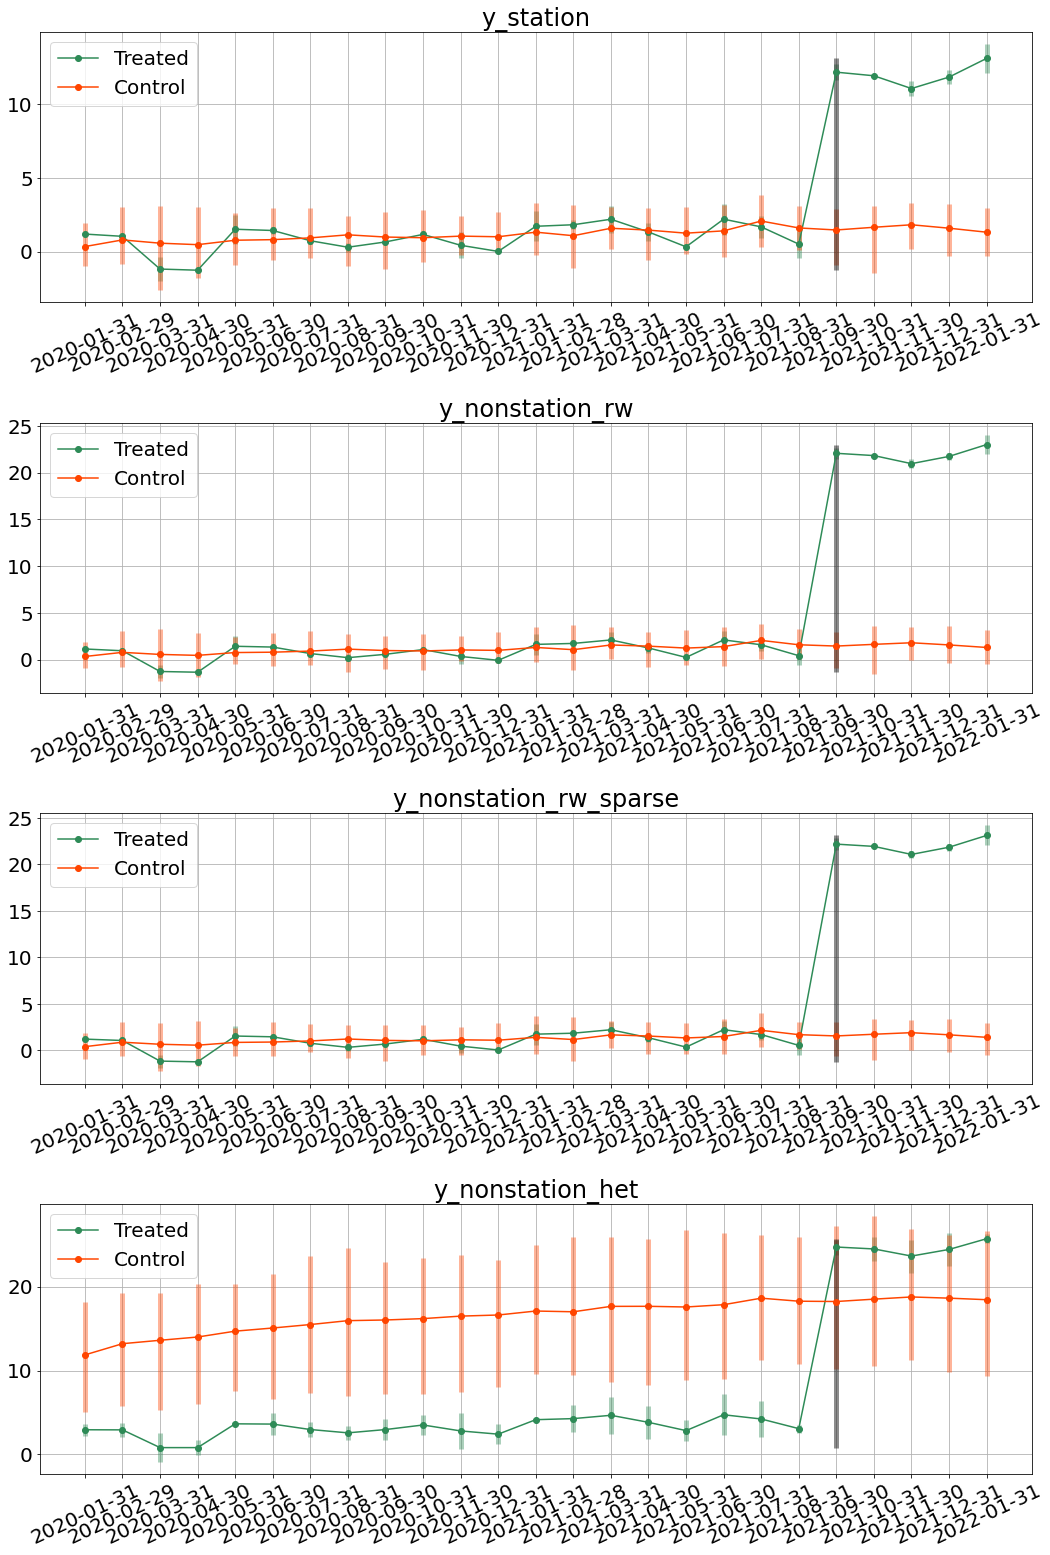

In [4]:
plt.rcParams.update({'font.size': 20})

fig,ax = plt.subplots(ncols=1,nrows=4, figsize=(15,22))
treatment_time = df.loc[df['W']==1]['date'].min()
for i,y in zip( range(4), [x for x in df.columns if 'y_' in x]):
    plot_mean = df.groupby(['date','treated_unit'])[y].mean().to_frame().reset_index()
    plot_p95 = df.groupby(['date','treated_unit'])[y].quantile(0.95).to_frame().reset_index()
    plot_p05 = df.groupby(['date','treated_unit'])[y].quantile(0.05).to_frame().reset_index()    
    ax[i].plot(plot_mean.loc[ (plot_mean['treated_unit']==1) ]['date'],
                  plot_mean.loc[ (plot_mean['treated_unit']==1) ][y],
                  '-o',
                 color='seagreen', label='Treated')
    ax[i].vlines(plot_mean.loc[ (plot_mean['treated_unit']==1) ]['date'],
                  plot_p95.loc[ (plot_mean['treated_unit']==1) ][y],
                  plot_p05.loc[ (plot_mean['treated_unit']==1) ][y],                 
                 color='seagreen', linewidth=5, alpha=0.40)
    
    ax[i].plot(plot_mean.loc[ (plot_mean['treated_unit']==0) ]['date'],
                  plot_mean.loc[ (plot_mean['treated_unit']==0) ][y],
                  '-o',
                 color='orangered', label='Control')
    ax[i].vlines(plot_mean.loc[ (plot_mean['treated_unit']==0) ]['date'],
                  plot_p95.loc[ (plot_mean['treated_unit']==0) ][y],
                  plot_p05.loc[ (plot_mean['treated_unit']==0) ][y],                 
                 color='orangered', linewidth=5, alpha=0.40)
    
    ax[i].vlines(x=treatment_time, ymin= plot_mean[y].min(), ymax=plot_mean[y].max() , 
                 color='black',alpha=0.45, linewidth=5)
    ax[i].set_xticklabels(labels=plot_mean.loc[ (plot_mean['treated_unit']==0) ]['date'],
                          rotation=25)
    ax[i].set_title(y)
    ax[i].legend()
    ax[i].grid()
    plt.tight_layout()


**Step 1** Estimate the regularization parameter

In [5]:
def comp_reg_parameter(data_control_pre=None,
                      data_control_pst=None,
                      data_treat_pre=None,
                      data_treat_pst=None):
    T_post = data_control_pst.shape[0]
    T_pre =  data_control_pre.shape[0]
    N_tr = data_treat_pst.shape[1]
    N_co = data_control_pst.shape[1]
    
    ## Calculate the AR(1) period-to-period change per control units
    delta_it = data_control_pre.shift(1).iloc[1:] - data_control_pre.iloc[1:]
    delta_bar = delta_it.sum().sum()
    delta_bar /= (N_co)*(T_pre-1)
    
    ## Calculate the variance of AR(1) period-to-period change
    sigma_hat = np.power( (delta_it - delta_bar), 2 ).sum().sum()
    sigma_hat /= (N_co)*(T_pre-1)
    zeta = np.power( N_tr * T_post , 0.25) * np.sqrt(sigma_hat)
    return zeta

**Step 2** Estimate the lambda parameter

**Step 3** Estimate the omega parameter. Keep in mind that the omega parameter is estimated without the lambda parameter as an input. In other words, they are estimated independently.

In [6]:
## This function is used for optmization of lambda
def l_unit(omega_array = None,
            zeta=0,
           data_control_pre=None,
                      data_control_pst=None,
                      data_treat_pre=None,
                      data_treat_pst=None):
    omega_0 = omega_array[0]
    omega_sdid = omega_array[1:]
    N_tr = data_treat_pst.shape[1]
        
    control_y = omega_0 + np.dot(data_control_pre, omega_sdid) 
    treat_y = data_treat_pre.sum(axis=1)
    treat_y /= N_tr
    
    regularization = zeta**2 * np.sum( omega_array**2 )
    control_treat_y = np.sum( (omega_0 + control_y - treat_y)**2 )
    return control_treat_y + regularization
def estimate_omega(data_control_pre=None,
                      data_control_pst=None,
                      data_treat_pre=None,
                      data_treat_pst=None):
    
    zeta_0 = comp_reg_parameter(data_control_pre=data_control_pre,
                  data_control_pst=data_control_pst,
                  data_treat_pre=data_treat_pre,
                  data_treat_pst=data_treat_pst)
    ## Initialize at a given point
    initial_omega = np.ones(data_control_pre.shape[1]+1)/ data_control_pre.shape[1] 
    
    omega_weights = fmin_slsqp(partial(l_unit, 
                       zeta=zeta_0,
                      data_control_pre=data_control_pre,
                      data_control_pst=data_control_pst,
                      data_treat_pre=data_treat_pre,
                      data_treat_pst=data_treat_pst),
                         initial_omega,
                             f_eqcons=lambda x: np.sum(x[1:]) - 1,
                               bounds=[(0.0, np.inf)]*len(initial_omega),
                             iter=50000, 
                             disp=False)
        

    return omega_weights    

def t_unit(lambda_array = None,
            zeta=0,
           data_control_pre=None,
                      data_control_pst=None,
                      data_treat_pre=None,
                      data_treat_pst=None):
    lambda_0 = lambda_array[0]
    lambda_sdid = lambda_array[1:]
    
    pre_y = lambda_0 + np.dot(lambda_sdid, data_control_pre)
    pst_y = data_control_pst.sum(axis=0)
    pst_y /= data_control_pst.shape[0]
    ## We do regularization following footnote 3 from SDiD Paper
    regularization = zeta**2*data_control_pre.shape[1]*np.sum( lambda_array**2 )
    
    pre_pst_y = np.power(pre_y + pst_y, 2).sum() 
    return pre_pst_y


def estimate_lambda(data_control_pre=None,
                      data_control_pst=None,
                      data_treat_pre=None,
                      data_treat_pst=None):
    
    zeta_0 = comp_reg_parameter(data_control_pre=data_control_pre,
                  data_control_pst=data_control_pst,
                  data_treat_pre=data_treat_pre,
                  data_treat_pst=data_treat_pst)
    ## Initialize at a given point
    initial_lambda = np.ones(data_control_pre.shape[0]+1)/ data_control_pre.shape[0] 
    
    lambda_weights = fmin_slsqp(partial(t_unit, 
                       zeta=zeta_0,
                      data_control_pre=data_control_pre,
                      data_control_pst=data_control_pst,
                      data_treat_pre=data_treat_pre,
                      data_treat_pst=data_treat_pst),
                         initial_lambda,
                             f_eqcons=lambda x: np.sum(x[1:]) - 1,
                               bounds=[(0.0, np.inf)]*len(initial_lambda),
                             iter=50000, 
                             disp=False)
    return lambda_weights 

In [7]:
# l_unit( omega_array = np.ones(sc_dict['C_pre'].shape[1]+1)/ sc_dict['C_pre'].shape[1],
#        zeta = 0.25,
#        data_control_pre=sc_dict['C_pre'],
#        data_control_pst=sc_dict['C_pst'],
#       data_treat_pre=sc_dict['T_pre'],
#       data_treat_pst=sc_dict['T_pst'])


**Step 4** After we estimate the regularization parameter (Step 1), omega weights (Step 2), and lambda weights (Step 3), we can estimate the SDiD Estimator.
*Note that we can use OLS, where we weight the observations based on the estimated omega and lambda weights to estimate the SDiD estimator.* We do **not** need to use the `sc_dict` style inputs used to estimate the omega and lamdba weights. 


In [8]:
def twfe_sdid(data=None,
        omega_weights=None,
        lambda_weights=None,
        data_dict={'treatment':None,
                  'date':None,
                  'post':None,
                  'unitid':None,
                  'outcome':None}):
    '''
    Output the ATET from the final statsmodel, and estimate the counterfactual trend.
    '''
    ## Construct the TWFE regression by creating time indicators and unit indicators
    ## This estimate treatment-unit specific treatment effects
    t_fe = pd.get_dummies(data[data_dict['date']]  ,drop_first=True)
    x_fe = pd.get_dummies(data[data_dict['unitid']],drop_first=True)

    ## Estimate a single ATET
    ## so construct a single indicator 
    treated_units = data.loc[data[data_dict['treatment']]==1][data_dict['unitid']].unique().tolist()
    post_treated = pd.DataFrame(
        data={'post_SDiD': 
        (data[data_dict['post']]*(data[data_dict['unitid']].isin(treated_units))).astype(float)})
    
    
    twfe_X = sm.add_constant( pd.concat([post_treated,  t_fe, x_fe ], axis=1)  )
    
    ## Before we construct the inputs for the OLS model, we need to 
    ## weight all the observations by the omega and lambda weights.
    ## To avoid errors from editting the dataframe, create a copy.
    y_array = data[[data_dict['outcome']]].copy()
    for omega_i,omega_hat in zip(data[ data_dict['unitid'] ].astype(int).sort_values().unique()
                                 ,
                                 omega_weights):
        twfe_X.loc[data[ data_dict['unitid']]==omega_i ] *= omega_hat
        y_array.loc[data[ data_dict['unitid']]==omega_i ] *= omega_hat       
    for lambda_t,lambda_hat in zip(data[ data_dict['date'] ].sort_values().unique()
                                   ,
                                   lambda_weights):
        twfe_X.loc[data[ data_dict['date']]==lambda_t ] *= lambda_hat
        y_array.loc[data[ data_dict['date']]==lambda_t ] *= lambda_hat
        
    twfe_model = sm.OLS(y_array,  twfe_X).fit()
    twfe_coef = twfe_model.params.iloc[0:2]
    twfe_se = twfe_model.bse.iloc[0:2]
    twfe_tstat = twfe_model.tvalues.iloc[0:2]
    twfe_pvalues = twfe_model.pvalues.iloc[0:2]

    df_twfe = pd.DataFrame()
    for r, coef_, se_, pv_ in zip(twfe_coef.index, twfe_coef, twfe_se, twfe_pvalues):
        df_twfe = pd.concat([df_twfe,
                                 pd.DataFrame(index=[r],
                                             data={
                                                  'coef_':coef_,
                                                  'se_':se_,
                                                  'pvalue':pv_}  )])  
    ## Predict counterfactual values
    c_df = pd.DataFrame()
    c_df['y'] = twfe_model.predict(twfe_X)
    c_df[data_dict['date']] = data[data_dict['date']].values
    c_df[data_dict['unitid']] = data[data_dict['unitid']].values    
    c_df[data_dict['treatment']] = data[data_dict['treatment']].values    
    c_df['post_SDiD'] = (data[data_dict['post']]*\
                         (data[data_dict['unitid']].isin(treated_units))).astype(float)
    c_df['y_c'] = c_df['y'] - c_df['post_SDiD']*df_twfe['coef_']['post_SDiD']
    c_df['y_obs'] = y_array.values
    c_df['stder'] = df_twfe['se_']['post_SDiD']
    return {'sdid':df_twfe, 'sdid_model':twfe_model, 'counterfactual':c_df}

In [9]:
## Clean data
y_outcome_of_interest = 'y_station'
sc_dict = dgp.clean_and_input_data(dataset=df,
                                   treatment='treated_unit', 
                                   date='date',
                                   post='post',
                                  outcome='y_station')

In [10]:
omega_p = estimate_omega(sc_dict['C_pre'],
                  sc_dict['C_pst'],
                  sc_dict['T_pre'],
                  sc_dict['T_pst'])
lambda_p = estimate_lambda(sc_dict['C_pre'],
                  sc_dict['C_pst'],
                  sc_dict['T_pre'],
                  sc_dict['T_pst'])

In [11]:
for omega_i,omega_hat in zip(df['unitid'].astype(int).sort_values().unique(),omega_p):
    print('Omega for unit {0}: {1:5.3f}'.format(omega_i, omega_hat))
for lambda_t,lambda_hat in zip(df['date'].sort_values().unique(),lambda_p):
    print('Lambda for time period {0}: {1:5.3f}'.format(pd.to_datetime(lambda_t).strftime("%Y-%m-%d")
                                                       , lambda_hat))

Omega for unit 0: 0.057
Omega for unit 1: 0.132
Omega for unit 2: 0.000
Omega for unit 3: 0.088
Omega for unit 4: 0.007
Omega for unit 5: 0.151
Omega for unit 6: 0.165
Omega for unit 7: 0.024
Omega for unit 8: 0.000
Omega for unit 9: 0.254
Omega for unit 10: 0.000
Omega for unit 11: 0.103
Omega for unit 12: 0.007
Omega for unit 13: 0.000
Omega for unit 14: 0.070
Omega for unit 15: 0.000
Lambda for time period 2020-01-31: 0.000
Lambda for time period 2020-02-29: 0.765
Lambda for time period 2020-03-31: 0.000
Lambda for time period 2020-04-30: 0.198
Lambda for time period 2020-05-31: 0.038
Lambda for time period 2020-06-30: 0.000
Lambda for time period 2020-07-31: 0.000
Lambda for time period 2020-08-31: 0.000
Lambda for time period 2020-09-30: 0.000
Lambda for time period 2020-10-31: 0.000
Lambda for time period 2020-11-30: 0.000
Lambda for time period 2020-12-31: 0.000
Lambda for time period 2021-01-31: 0.000
Lambda for time period 2021-02-28: 0.000
Lambda for time period 2021-03-31: 0

In [12]:
sdid_results = twfe_sdid(data=df,
         omega_weights=omega_p,
         lambda_weights=lambda_p,
         data_dict={'treatment':'treated_unit',
                   'date':'date',
                   'post':'post',
                   'unitid':'unitid',
                   'outcome':'y_station'})

In [13]:
display(sdid_results['sdid'])
display(sdid_results['sdid_model'].summary())

,coef_,se_,pvalue
const,-16442.997357,2.540801e+09,9.999948e-01
post_SDiD,10.254080,4.519887e-01,1.954606e-73


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              y_station   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              217.9
Date:                Sun, 15 Jan 2023   Prob (F-statistic):                   1.22e-228
Time:                        12:15:47   Log-Likelihood:                         -238.94
No. Observations:                 425   AIC:                                      541.9
Df Residuals:                     393   BIC:                                      671.6
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.644e+04   2.54e+09  -6.47e-06      1.000      -5e+09       5e+09
post_SDiD     10.2541      0.452     22.687      0.000       9.365      11.143
2020-02-29  1.644e+04   2.54e+09   6.47e-06      1.000      -5e+09       5e+09
2020-03-31  1.644e+04   7.09e+09   2.32e-06      1.000   -1.39e+10    1.39e+10
2020-04-30  1.644e+04   2.54e+09   6.47e-06      1.000      -5e+09       5e+09
2020-05-31  1.644e+04   2.54e+09   6.47e-06      1.000      -5e+09       5e+09
2020-06-30     0.0657    1.2e+05   5.46e-07      1.000   -2.37e+05    2.37e+05
2020-07-31     0.0161   4.56e+04   3.53e-07      1.000   -8.96e+04    8.96e+04
2020-08-31    -0.0215   2.95e+04   -7.3e-07      1.000   -5.79e+04    5.79e+04
2020-09-30  1.644e+04   1.25e+10   1.31e-06      1.000   -2.46e+10    2.46e+10
2020-10-31    -0.0196   3.53e+04  -5.56e-07      1.000   -6.93e+04    6.93e+04
2020-11-30    -0.0107   2.26e+04  -4.73e-07      1.000   -4.43e+04    4.43e+04
2020-12-31     0.0019    4.6e+04   4.14e-08      1.000   -9.03e+04    9.03e+04
2021-01-31    -0.0403   8.88e+04  -4.54e-07      1.000   -1.75e+05    1.75e+05
2021-02-28    -0.0092   2.18e+04   -4.2e-07      1.000   -4.29e+04    4.29e+04
2021-03-31  1.644e+04   3.13e+10   5.26e-07      1.000   -6.15e+10    6.15e+10
2021-04-30  1.644e+04   8.72e+09   1.89e-06      1.000   -1.72e+10    1.72e+10
2021-05-31  1.644e+04   9.19e+09   1.79e-06      1.000   -1.81e+10    1.81e+10
2021-06-30    -0.0443   9.33e+04  -4.75e-07      1.000   -1.83e+05    1.83e+05
2021-07-31    -0.0488   9.96e+04   -4.9e-07      1.000   -1.96e+05    1.96e+05
2021-08-31  1.644e+04   4.69e+09   3.51e-06      1.000   -9.21e+09    9.21e+09
2021-09-30  1.644e+04   5.87e+09    2.8e-06      1.000   -1.15e+10    1.15e+10
2021-10-31  1.644e+04   2.54e+09   6.47e-06      1.000      -5e+09       5e+09
2021-11-30  1.644e+04   2.54e+09   6.47e-06      1.000      -5e+09       5e+09
2021-12-31  1.644e+04   2.54e+09   6.47e-06      1.000      -5e+09       5e+09
2022-01-31  1.644e+04   2.54e+09   6.47e-06      1.000      -5e+09       5e+09
1              0.0601      0.290      0.207      0.836      -0.511       0.631
10             0.0110      0.487      0.023      0.982      -0.946       0.968
11            -0.7291      0.487     -1.497      0.135      -1.686       0.228
12             0.1786      0.487      0.367      0.714      -0.779       1.136
13            -2.5028      0.487     -5.140      0.000      -3.460      -1.546
14            -0.0760      0.487     -0.156      0.876      -1.033       0.881
15             0.2649      0.487      0.544      0.587      -0.692       1.222
16            -0.7827      0.487     -1.607      0.109      -1.740       0.175
2             -0.1603      0.487     -0.329      0.742      -

In [14]:
display(sdid_results['counterfactual'].loc[sdid_results['counterfactual']['post_SDiD']==1])

,y,date,unitid,treated_unit,post_SDiD,y_c,y_obs,stder
340,2.406618e-10,2021-09-30,0,1.0,1.0,-10.254080,2.577491e-10,0.451989
357,1.199226e+01,2021-10-31,0,1.0,1.0,1.738183,1.186594e+01,0.451989
374,1.203989e+01,2021-11-30,0,1.0,1.0,1.785810,1.047006e+01,0.451989
391,1.192647e+01,2021-12-31,0,1.0,1.0,1.672386,1.128796e+01,0.451989
408,1.183621e+01,2022-01-31,0,1.0,1.0,1.582125,1.416127e+01,0.451989
341,2.418765e-10,2021-09-30,1,1.0,1.0,-10.254080,2.342897e-10,0.451989
358,1.205234e+01,2021-10-31,1,1.0,1.0,1.798256,1.197960e+01,0.451989
375,1.209996e+01,2021-11-30,1,1.0,1.0,1.845883,1.164727e+01,0.451989
392,1.198654e+01,2021-12-31,1,1.0,1.0,1.732460,1.238044e+01,0.451989
409,1.189628e+01,2022-01-31,1,1.0,1.0,1.642199,1.203741e+01,0.451989
